### Problem 3.7
Consider fitting the model in equation 3.1 using a least squares loss function. Does this loss function have a unique minimum? i.e., is there a single “best” set of parameters?

**Equation 3.1**

![eqn3.1](exer_screenshots/eqn3.1.png)

**Least Square Loss Function**

![least_squares](exer_screenshots/least-squares-loss.png)

### How to Approach this Problem
- Train Several Shallow Networks. And observe any similarities between each of the weights. Randomly select few weights and correlate each of them per prediction.
- Each networks should have different initial weights. If they have unique "single best parameters" or if a "global minimum exists", then they should converge the same.

Platform 'METAL' is experimental and not all JAX functionality may be correctly supported!
2024-01-28 17:06:49.840764: W pjrt_plugin/src/mps_client.cc:563] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!


Metal device set to: Apple M3 Max

systemMemory: 36.00 GB
maxCacheSize: 13.50 GB

(500,) (500,)


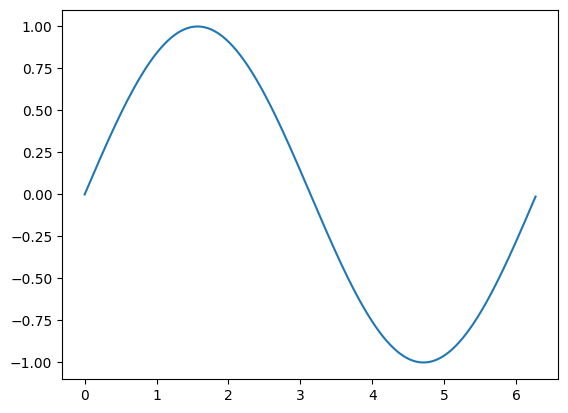

x.shape =  (500, 1)
y.shape =  (500, 1)


In [2]:
import jax.numpy as jnp
import math
import matplotlib.pyplot as plt

# print(math.pi)
x_input = jnp.arange(0, stop=2*math.pi, step= 2*math.pi / (500))
y_target = jnp.sin(x_input)

print(x_input.shape, y_target.shape)
plt.plot(x_input,y_target)
plt.show()

x_input = x_input.reshape((-1,1))
y_target = y_target.reshape((-1,1))

print('x.shape = ', x_input.shape)
print('y.shape = ', y_target.shape)

In [ ]:
import jax.numpy as jnp
from jax import grad, jit, vmap, jacobian
from jax import random
from jaxlib.xla_extension import ArrayImpl
import math
from jax.scipy.special import logsumexp
import numpy as np


# A helper function to randomly initialize weights and biases
# for a dense neural network layer
def random_layer_params(m, n, key, scale=1e-2):
  w_key, b_key = random.split(key)
  return scale * random.normal(w_key, (m, n)), scale * random.normal(b_key, (n,))

# Initialize all layers for a fully-connected neural network with sizes "sizes"
def init_network_params(input_sizes, output_sizes, key):
  assert len(input_sizes) == len(output_sizes), 'input_sizes != output_sizes'
  keys = random.split(key, len(input_sizes))
  return [random_layer_params(m, n, k) for m, n, k in zip(input_sizes, output_sizes, keys)]

def display_params(params, params_name):
   print(f'{params_name} total num_layers = ', len(params))
   for level, param in enumerate(params, start=1):
      weight_shape = param[0].shape
      bias_shape = param[1].shape
      print(f'({level}) {params_name}_weights.shape = {weight_shape}, {params_name}_bias.shape = {bias_shape}')

def relu(x):
    return jnp.where(x >= 0, x, 0)

def mse(y_pred,y_target):
    return jnp.mean((y_pred - y_target) ** 2)

def linear(W, x):
    return x @ W

def predict(params, x_input):
    activations = x_input 
    for w, b in params[:-1]:
        outputs = activations @ w + b
        activations = relu(outputs)
    
    final_w = params[-1][0]
    final_b = params[-1][1]

    logits = activations @ final_w + final_b
    return jnp.tanh(logits)

@jit
def loss_func(params, x_input, targets):
  preds = predict(params, x_input)
  return mse(preds, targets)

def update_weights(params, x, y, step_size):
  grads = grad(loss_func)(params, x, y)

  return [(w - step_size * dw, b - step_size * db)
          for (w, b), (dw, db) in zip(params, grads)]

def train_network(num_hidden, num_epochs, step_display):
  input_sizes = [1, num_hidden]
  output_sizes = [num_hidden, 1]

  random_seed = np.random.randint(0,1024)
  params = init_network_params(input_sizes, output_sizes, random.PRNGKey(random_seed))
  display_params(params, 'network_params')
  step_size = 0.01

  for curr_epoch in range(1, num_epochs + 1):
    loss = loss_func(params, x_input, y_target)
    params = update_weights(params, x_input, y_target, step_size)
    if curr_epoch % step_display == 0:
      print(f'[{curr_epoch}/{num_epochs}] Loss: {loss}')

  return params

def compare_params_two_weights(num_hidden, num_epochs, step_display):
  print('training params_v1: ')
  params_v1 = train_network(num_hidden, num_epochs, step_display)
  print('')
  print('training params_v2: ')
  params_v2 = train_network(num_hidden, num_epochs, step_display)
  params_v1_flatten = []
  params_v2_flatten = []

  for prm_v1, prm_v2 in zip(params_v1, params_v2):
      params_v1_flatten.extend(prm_v1[0].reshape(-1).tolist())
      params_v2_flatten.extend(prm_v2[0].reshape(-1).tolist())

  corr = np.corrcoef(params_v1_flatten, params_v2_flatten)[0,1]
  return corr

epoch_rounds = [ 100 * i for i in range(1, 20)]

corrs_per_epoch = []

for num_epoch in epoch_rounds:
   corr = compare_params_two_weights(2, num_epoch, num_epoch // 2)
   corrs_per_epoch.append(corr)

# for 


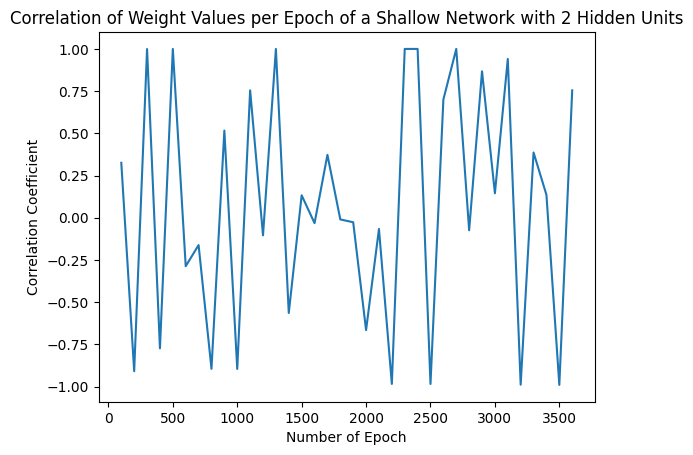

In [36]:
plt.plot(epoch_rounds[0:len(corrs_per_epoch)], corrs_per_epoch)
plt.title('Correlation of Weight Values per Epoch of a Shallow Network with 2 Hidden Units')
plt.ylabel('Correlation Coefficient')
plt.xlabel('Number of Epoch')
plt.show()

### Conclusion on the Experiment
- Empirically, there's no sign that weights of two different network converges to the same parameter. For every increase in epoch, there's no sign of stabilizing correlation.
- We should expect some sort of **Logarithmic curve** if there's a single best parameter that represents the best maximum value.

### However
- We might be misrepresenting something in our experiment

### As per GPT4/Andy

As per Andy, if the Neural Network is a single layer aka $y = Wx + b$, since the least square is convex, then there exist a single best parameter that represents the best maximum value. But clearly, this is not the case on the example that's given on the book.